![](https://i.postimg.cc/13h3fNN7/image0.jpg)

> In this notebook, I explore a dataset from the Epic Games Store (2008-2022) to explore insights into game pricing, release trends, and how various factors influence game performance and perceived value. My goal is to explore the relationship between key game features—such as genres, developers, description length, sentiment, and release timing—and how they impact pricing and platform availability. By answering key questions around pricing strategies, seasonality, and sentiment, I aim to deepen my understanding of the dynamics within the Epic Games Store.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

### Load data

In [2]:
games = pd.read_csv('/kaggle/input/epic-games-store-dataset/games.csv')
games.head()

,id,name,game_slug,price,release_date,platform,description,developer,publisher,genres
0,4c81547b81064acfb1902be7b06d6366,Assassin's Creed® I: Director's Cut,assassins-creed-1,1999,2008-04-09T15:00:00.000Z,Windows,"You are an Assassin, a warrior shrouded in sec...",Ubisoft,Ubisoft,"ACTION,RPG"
1,3fdbd69050ec4091a68481b397f0a5dd,LEGO® Batman™: The Videogame,lego-batman,1999,2008-09-28T15:00:00.000Z,Windows,When all the villains in Arkham Asylum team up...,Traveller's Tales,Warner Bros.,ACTION
2,5f82cbea3fdd42e2b9b9dfe8439b96b3,World of Goo,world-of-goo,1499,2008-10-13T15:00:00.000Z,"Windows,Mac",You Can't Stop Progress,2D Boy,2D Boy,"INDIE,PUZZLE"
3,497cdc35842e458ca10a1edae95ae181,Shadow Complex Remastered,shadow-complex,1499,2009-08-19T14:00:00.000Z,"Mac,Windows",SHADOW COMPLEX IS BACK....AND BETTER THAN EVER!,Epic Games,Epic Games,ACTION
4,0dfa5a4398bb44c8b1ac34e5f248fab9,Metro 2033 Redux,metro-2033-redux,1999,2010-03-16T15:00:00.000Z,NaN,"In 2013, the world was devastated by an apocal...",4A Games,Deep Silver,"SHOOTER,FPS"


### Game Pricing Insights:

### 1) What factors most strongly influence game pricing across different genres and developers?
- explore relationships between variables like developer, publisher, and genres on the pricing strategies of games

#### Data preparation

In [3]:
# Convert release_date to datetime and extract year
games['release_year'] = pd.to_datetime(games['release_date']).dt.year
# fill nan values in priceing with the median if needed
games['price'] = games['price'].fillna(games['price'].median())
# divide all price by 100 to get the true value
games['price'] = games['price']/100
print(games['price'])

0      19.99
1      19.99
2      14.99
3      14.99
4      19.99
       ...  
910    19.99
911     9.99
912     0.00
913    24.99
914    29.99
Name: price, Length: 915, dtype: float64


In [4]:
games.head()

,id,name,game_slug,price,release_date,platform,description,developer,publisher,genres,release_year
0,4c81547b81064acfb1902be7b06d6366,Assassin's Creed® I: Director's Cut,assassins-creed-1,19.99,2008-04-09T15:00:00.000Z,Windows,"You are an Assassin, a warrior shrouded in sec...",Ubisoft,Ubisoft,"ACTION,RPG",2008
1,3fdbd69050ec4091a68481b397f0a5dd,LEGO® Batman™: The Videogame,lego-batman,19.99,2008-09-28T15:00:00.000Z,Windows,When all the villains in Arkham Asylum team up...,Traveller's Tales,Warner Bros.,ACTION,2008
2,5f82cbea3fdd42e2b9b9dfe8439b96b3,World of Goo,world-of-goo,14.99,2008-10-13T15:00:00.000Z,"Windows,Mac",You Can't Stop Progress,2D Boy,2D Boy,"INDIE,PUZZLE",2008
3,497cdc35842e458ca10a1edae95ae181,Shadow Complex Remastered,shadow-complex,14.99,2009-08-19T14:00:00.000Z,"Mac,Windows",SHADOW COMPLEX IS BACK....AND BETTER THAN EVER!,Epic Games,Epic Games,ACTION,2009
4,0dfa5a4398bb44c8b1ac34e5f248fab9,Metro 2033 Redux,metro-2033-redux,19.99,2010-03-16T15:00:00.000Z,NaN,"In 2013, the world was devastated by an apocal...",4A Games,Deep Silver,"SHOOTER,FPS",2010


In [5]:
# one-hot encode genres, developer. and publisher
games_encoded = pd.get_dummies(games, columns=['developer', 'publisher', 'genres'], drop_first=True)

In [6]:
# select features for the model
X = games_encoded[['release_year'] + list(games_encoded.filter(like='developer_').columns) + list(games_encoded.filter(like='publisher_').columns) + list(games_encoded.filter(like='genres_').columns)]
y = games_encoded['price']

In [7]:
# will use Random Forest 'cause it allows us to compute feature importance to see which variables have the greatest impact on pricing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# init and fit model
model = RandomForestRegressor()
model.fit(X_train, y_train)
# make predictions
y_pred = model.predict(X_test)
# calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 14.980915690315266


#### Feature Importance

In [8]:
# feature importance
importances = model.feature_importances_
# to display the result in a DataFrame
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
# sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df.head(10))

                              Feature  Importance
0                        release_year    0.056243
832             publisher_Square Enix    0.040756
753       publisher_NIS America, Inc.    0.031030
871                 publisher_Ubisoft    0.022250
1336         genres_RPG,SINGLE_PLAYER    0.021512
574                      publisher_2K    0.014406
512         developer_Ubisoft Toronto    0.013398
1302  genres_RACING,SIMULATION,SPORTS    0.011690
808                    publisher_SEGA    0.011538
86           developer_CD PROJEKT RED    0.011361


#### Visualization

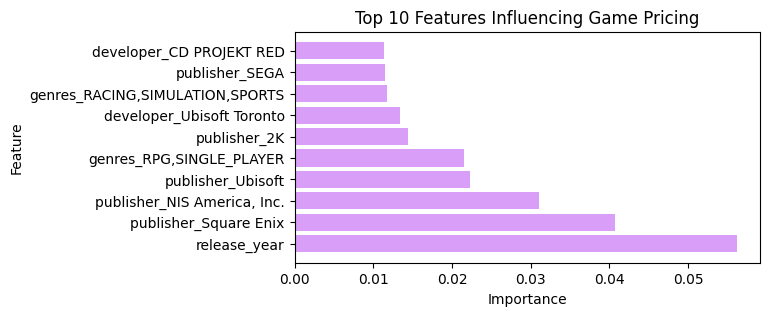

In [9]:
plt.figure(figsize=(6, 3))
plt.barh(feature_importance_df['Feature'][:10], feature_importance_df['Importance'][:10], color='#d99ef7')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Features Influencing Game Pricing')
plt.show()

> #### **Conclusion**:
> ##### * Release year remains a major impactor, as older games are typically discounted while newer releases maintain higher prices
> ##### * Larger publisers (e.g., Square Enix, Ubisoft, SEGA) and renowned developers (e.g., CD PROJEKT RED) often charge higher price for their games (e.g., brand power and consumer trust)
> ##### * Genres like RPG, SINGLE_PLAYER and RACING, SIMULATION, SPORTS also have a significant impact on game pricing (e.g., more populor, complex)

### 2) Which genres tend to be associated with higher game prices, and does this vary by platform or developer?
- can help understand the market dynamics for different genres across platforms and developers, potentially adjusting pricing for future releases

In [10]:
# prepare data
games_genres = games.copy()
# drop nan rows for genres
games_genres = games_genres.dropna(subset=['genres'])
# split genres into multiple rows for each genre
games_genres['genres'] = games_genres['genres'].str.split(',')
games_genres = games_genres.explode('genres')

# drop rows with missing/invalid data for these columns
games_genres = games_genres.dropna(subset=['price', 'developer', 'platform'])
games_genres.head()

,id,name,game_slug,price,release_date,platform,description,developer,publisher,genres,release_year
0,4c81547b81064acfb1902be7b06d6366,Assassin's Creed® I: Director's Cut,assassins-creed-1,19.99,2008-04-09T15:00:00.000Z,Windows,"You are an Assassin, a warrior shrouded in sec...",Ubisoft,Ubisoft,ACTION,2008
0,4c81547b81064acfb1902be7b06d6366,Assassin's Creed® I: Director's Cut,assassins-creed-1,19.99,2008-04-09T15:00:00.000Z,Windows,"You are an Assassin, a warrior shrouded in sec...",Ubisoft,Ubisoft,RPG,2008
1,3fdbd69050ec4091a68481b397f0a5dd,LEGO® Batman™: The Videogame,lego-batman,19.99,2008-09-28T15:00:00.000Z,Windows,When all the villains in Arkham Asylum team up...,Traveller's Tales,Warner Bros.,ACTION,2008
2,5f82cbea3fdd42e2b9b9dfe8439b96b3,World of Goo,world-of-goo,14.99,2008-10-13T15:00:00.000Z,"Windows,Mac",You Can't Stop Progress,2D Boy,2D Boy,INDIE,2008
2,5f82cbea3fdd42e2b9b9dfe8439b96b3,World of Goo,world-of-goo,14.99,2008-10-13T15:00:00.000Z,"Windows,Mac",You Can't Stop Progress,2D Boy,2D Boy,PUZZLE,2008


#### Average Price by Genre

In [11]:
avg_price_by_genre = games_genres.groupby('genres')['price'].mean().sort_values(ascending=False)
print("Average Price by Genre:")
print(avg_price_by_genre.head(10))

Average Price by Genre:
genres
ROLE_PLAYING     39.990000
4X               38.990000
OPEN_WORLD       33.447708
SPORTS           33.375385
FANTASY          31.353636
TURN_BASED       30.170606
RPG              29.945752
SINGLE_PLAYER    28.095000
CO_OP            28.067949
CITY_BUILDER     27.132857
Name: price, dtype: float64


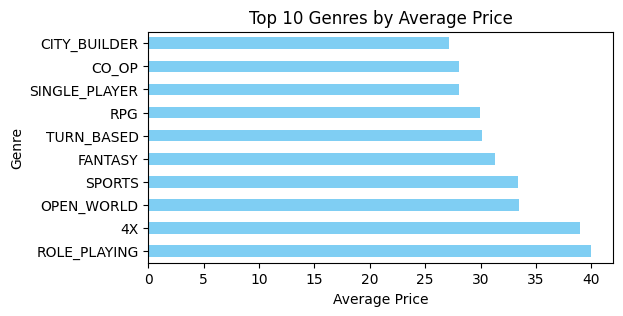

In [12]:
plt.figure(figsize=(6, 3))
avg_price_by_genre.head(10).plot(kind='barh', color='#7fcef3')
plt.title('Top 10 Genres by Average Price')
plt.xlabel('Average Price')
plt.ylabel('Genre')
plt.show()

#### Average Price by Genre and Platform

In [13]:
# replace inconsistent platform names with normal names
games_genres['platform'] = games_genres['platform'].replace({
    'Windows,MAC': 'Windows,Mac',
    'Mac,Windoes': 'Mac,Windows',  # Correct the typo
    'Windows, Mac': 'Windows,Mac',
    'windows': 'Windows',
    'Windows,Mac - Coming Soon': 'Windows,Mac'
})

# drop any remaining rows with NaN in the price or platform columns
games_genres = games_genres.dropna(subset=['price', 'platform'])

In [14]:
avg_price_by_genre_platform  = games_genres.groupby(['genres', 'platform'])['price'].mean().unstack()

print("Average Price by Genre and Platform:")
print(avg_price_by_genre_platform[:5])

Average Price by Genre and Platform:
platform       Mac,Windows    Windows  Windows,Mac  Windows,Mac OS  \
genres                                                               
4X                     NaN  36.240000    49.990000             NaN   
ACTION           17.490000  26.841538    20.451538             NaN   
ADVENTURE        16.323333  23.222704    19.714138             NaN   
ARCADE                 NaN  19.920000    14.990000             NaN   
BASE_BUILDING          NaN  24.990000    29.990000             NaN   

platform       Windows,Mac,Win32  Windows,Win32  
genres                                           
4X                           NaN            NaN  
ACTION                       NaN          18.49  
ADVENTURE                    NaN            NaN  
ARCADE                       NaN            NaN  
BASE_BUILDING                NaN            NaN  


platform      Mac,Windows    Windows  Windows,Mac  Windows,Mac OS  \
genres                                                              
4X                    NaN  36.240000    49.990000             NaN   
ROLE_PLAYING          NaN  39.990000          NaN             NaN   
SPORTS                NaN  32.172727    39.990000             NaN   
FPS                   NaN  24.991739    44.990000             NaN   
TURN_BASED            NaN  29.797692    31.555714             NaN   

platform      Windows,Mac,Win32  Windows,Win32  
genres                                          
4X                          NaN            NaN  
ROLE_PLAYING                NaN            NaN  
SPORTS                      NaN            NaN  
FPS                         NaN            NaN  
TURN_BASED                  NaN            NaN  


<Figure size 400x300 with 0 Axes>

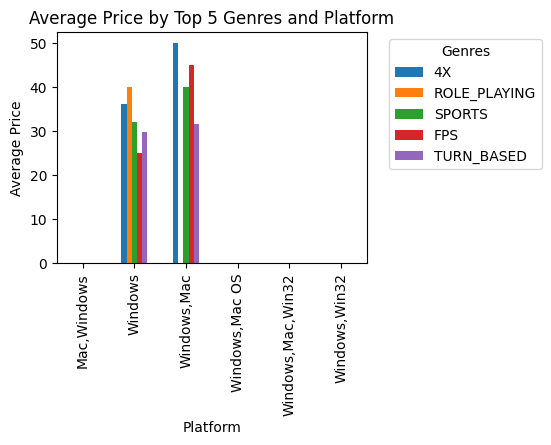

In [15]:
# get the top 5 genres by average price
top_5_genres = avg_price_by_genre_platform.mean(axis=1).nlargest(5).index

# filter the dataset to include only the top 5 genres
top_5_data = avg_price_by_genre_platform.loc[top_5_genres]
print(top_5_data)
plt.figure(figsize=(4, 3))
top_5_data.T.plot(kind='bar', stacked=False, figsize=(4, 3))
plt.title('Average Price by Top 5 Genres and Platform')
plt.xlabel('Platform')
plt.ylabel('Average Price')
plt.legend(title='Genres', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

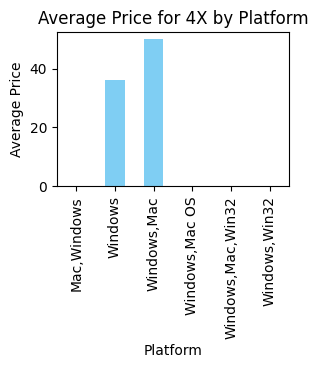

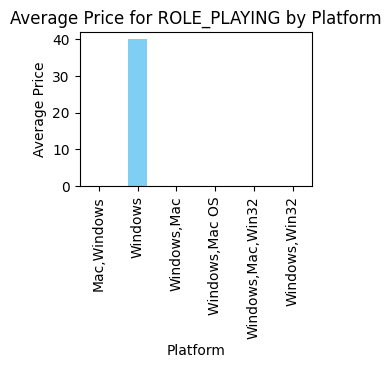

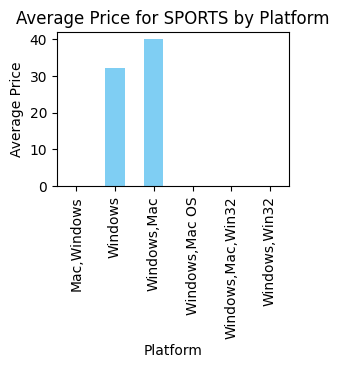

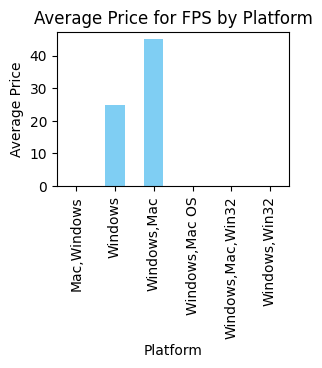

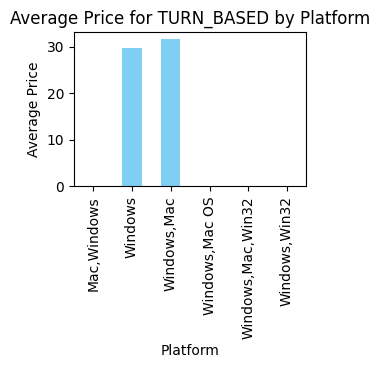

In [16]:
# create individual plots for the top 5 genres
for genre in top_5_genres:
    plt.figure(figsize=(3, 2))
    avg_price_by_genre_platform.loc[genre].plot(kind='bar', color='#7fcef3')
    plt.title(f'Average Price for {genre} by Platform')
    plt.xlabel('Platform')
    plt.ylabel('Average Price')
    plt.show()

> #### **Conclusion**:
> ##### * RPG, 4X, Open World, Sports, and Fantasy genres are associated with the highest game prices
> ##### * multi-platform games (e.g., Windows, Mac) --> higher prices, especially in genres like 4X and FPS

### 3) Are there specific times of the year (seasonality) when game releases see a higher concentration across certain genres or developers?
- could use this insight for future release planning to maximize sales and user engagement based on seasonality trends.

#### Data Preparation

In [17]:
# extract month
games['release_month'] = pd.to_datetime(games['release_date']).dt.month
games_season = games.copy()
# split the 'genres' column into multiple genres
games_season['genres'] = games_season['genres'].str.split(',')
# so that each genre gets its own row
games_season = games_season.explode('genres')

# group by month and genre; ensure missing values = 0
monthly_releases_by_genre = games_season.groupby(['release_month', 'genres']).size().unstack(fill_value=0)
# group by month and developer
monthly_releases_by_developer = games_season.groupby(['release_month', 'developer']).size().unstack(fill_value=0)

#### Seanson analysis

#### 1) By genre

<Figure size 500x300 with 0 Axes>

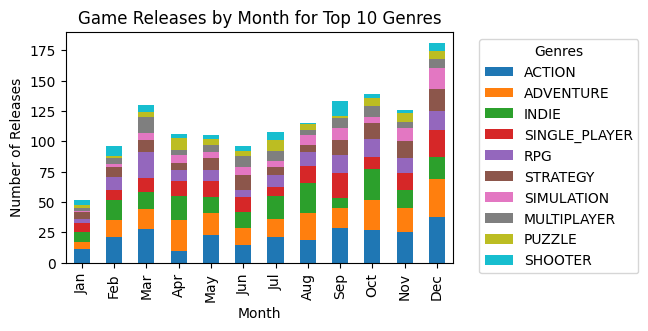

In [18]:
# top 10 genres by number of releases
top_10_genres = games_season['genres'].value_counts().nlargest(10).index
filtered_data = monthly_releases_by_genre[top_10_genres]

# visualize the game releases by month for the top 10 genres
plt.figure(figsize=(5, 3))
filtered_data.plot(kind='bar', stacked=True, figsize=(5, 3))
plt.title('Game Releases by Month for Top 10 Genres')
plt.xlabel('Month')
plt.ylabel('Number of Releases')
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Genres', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

<Figure size 500x300 with 0 Axes>

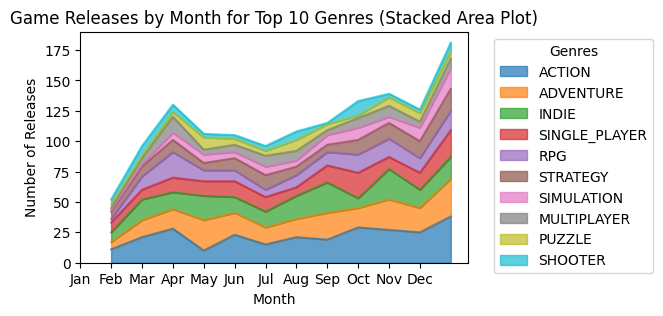

In [19]:
# stacked area plot for the top 10 genres by number of releases
plt.figure(figsize=(5, 3))
filtered_data.plot(kind='area', stacked=True, figsize=(5, 3), alpha=0.7)
plt.title('Game Releases by Month for Top 10 Genres (Stacked Area Plot)')
plt.xlabel('Month')
plt.ylabel('Number of Releases')
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Genres', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

> #### **Conclusion**:
> ##### * The highest concentration of game releases occurs in October and December across all genres.
> ##### * Action, RPG, Simulation, and Indie genres consistently see more releases towards the end of the year, especially during the months of October and December, likely due to the holiday season when user engagement and game purchases typically peak.
> ##### * A noticeable dip in game releases in January, with a steady increase as the year progresses --> the first quarter of the year has fewer releases.

#### 2) By developer

<Figure size 500x300 with 0 Axes>

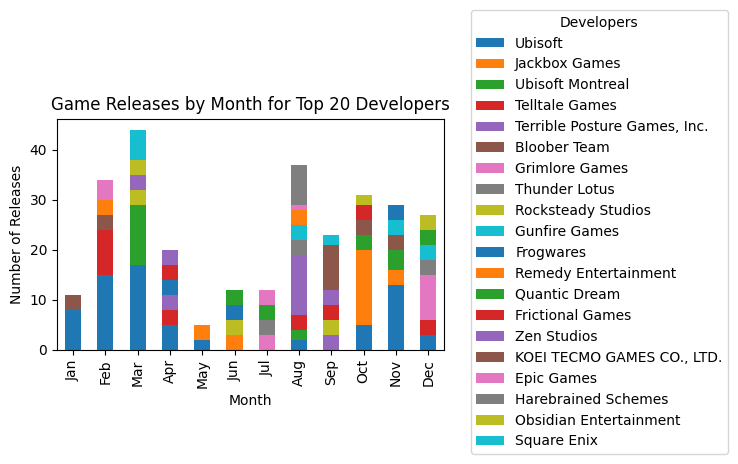

In [20]:
# top 20 developers by number of releases
top_20_developers = games_season['developer'].value_counts().nlargest(20).index
filtered_data_developer = monthly_releases_by_developer[top_20_developers]

# visualize the game releases by month for the top 20 developers
plt.figure(figsize=(5, 3))
filtered_data_developer.plot(kind='bar', stacked=True, figsize=(5, 3))
plt.title('Game Releases by Month for Top 20 Developers')
plt.xlabel('Month')
plt.ylabel('Number of Releases')
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Developers', bbox_to_anchor=(1.05, 1.5), loc='upper left')
plt.show()

<Figure size 600x400 with 0 Axes>

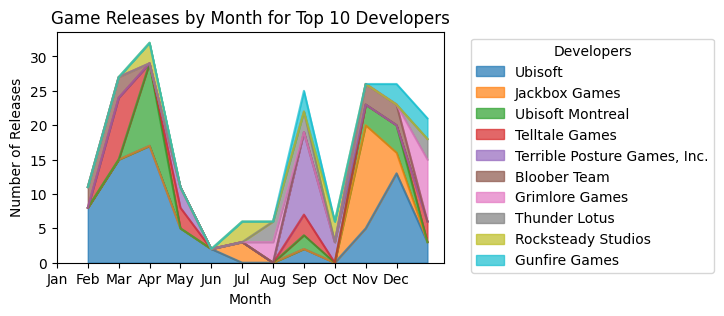

In [21]:
top_10_developers = games_season['developer'].value_counts().nlargest(10).index
filtered_data_developer = monthly_releases_by_developer[top_10_developers]

plt.figure(figsize=(6, 4))
filtered_data_developer.plot(kind='area', stacked=True, figsize=(5, 3), alpha=0.7)
plt.title('Game Releases by Month for Top 10 Developers')
plt.xlabel('Month')
plt.ylabel('Number of Releases')
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Developers', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

> #### **Conclusion**:
> ##### * Ubisoft, Square Enix, and Ubisoft Montreal show a significant concentration of releases in February and October, which aligns with major gaming events and the holiday sales period.
> ##### * Other developers (e.g., Telltale Games and Jackbox Games) show varied release patterns, with some releasing more games in June and August (e.g., summer promotions).
> ##### * April and May also see moderate releases by several developers, indicating pre-summer game launches.

### 4) How do release dates influence game pricing, and does the timing of release (e.g., during major gaming events or holidays) impact price and platform availability?
- explore if games released during specific events or holidays are priced differently

#### Categorize releases dates based on sale period
* February Savings: February 1 – February 15
* End of Winter Sale: March 7 – March 14
* Spring Sale: March 14 – March 28
* Mega Sale: May 16 – June 13
* Summer Sale: July 18 – August 1
* Halloween Sale: October 16 – October 30
* Black Friday Sale: November 19 – November 26
* The Game Awards Sale: December 5 – December 7
* Holiday Sale: December 11 – January 2

In [22]:
games['release_date']

0      2008-04-09T15:00:00.000Z
1      2008-09-28T15:00:00.000Z
2      2008-10-13T15:00:00.000Z
3      2009-08-19T14:00:00.000Z
4      2010-03-16T15:00:00.000Z
                 ...           
910    2022-02-08T16:00:00.000Z
911    2022-02-10T14:00:00.000Z
912    2022-02-10T15:45:00.000Z
913    2022-02-10T16:30:00.000Z
914    2022-02-10T17:00:00.000Z
Name: release_date, Length: 915, dtype: object

In [23]:
# convert the 'release_date' column to datetime; converted to timezone-naive datetime format
games['release_date'] = pd.to_datetime(games['release_date'], errors='coerce').dt.tz_localize(None)

def categorize_sale_period(date):
    year = date.year
    if pd.Timestamp(f'{year}-02-01') <= date <= pd.Timestamp(f'{year}-02-15'):
        return 'February Savings'
    elif pd.Timestamp(f'{year}-03-07') <= date <= pd.Timestamp(f'{year}-03-14'):
        return 'End of Winter Sale'
    elif pd.Timestamp(f'{year}-03-14') <= date <= pd.Timestamp(f'{year}-03-28'):
        return 'Spring Sale'
    elif pd.Timestamp(f'{year}-05-16') <= date <= pd.Timestamp(f'{year}-06-13'):
        return 'Mega Sale'
    elif pd.Timestamp(f'{year}-07-18') <= date <= pd.Timestamp(f'{year}-08-01'):
        return 'Summer Sale'
    elif pd.Timestamp(f'{year}-10-16') <= date <= pd.Timestamp(f'{year}-10-30'):
        return 'Halloween Sale'
    elif pd.Timestamp(f'{year}-11-19') <= date <= pd.Timestamp(f'{year}-11-26'):
        return 'Black Friday Sale'
    elif pd.Timestamp(f'{year}-12-05') <= date <= pd.Timestamp(f'{year}-12-07'):
        return 'The Game Awards Sale'
    elif pd.Timestamp(f'{year}-12-11') <= date <= pd.Timestamp(f'{year}-01-02'):
        return 'Holiday Sale'
    else:
        return 'Other'

games['sale_period'] = games['release_date'].apply(categorize_sale_period)

# Check the first few rows with the sale period labels
print(games[['release_date', 'sale_period']].tail())

           release_date       sale_period
910 2022-02-08 16:00:00  February Savings
911 2022-02-10 14:00:00  February Savings
912 2022-02-10 15:45:00  February Savings
913 2022-02-10 16:30:00  February Savings
914 2022-02-10 17:00:00  February Savings


Average game prices by sale period:
sale_period
End of Winter Sale      18.741250
February Savings        20.027143
Spring Sale             21.917805
Summer Sale             22.862308
Mega Sale               26.053968
Halloween Sale          26.373500
The Game Awards Sale    27.990000
Black Friday Sale       30.656667
Name: price, dtype: float64


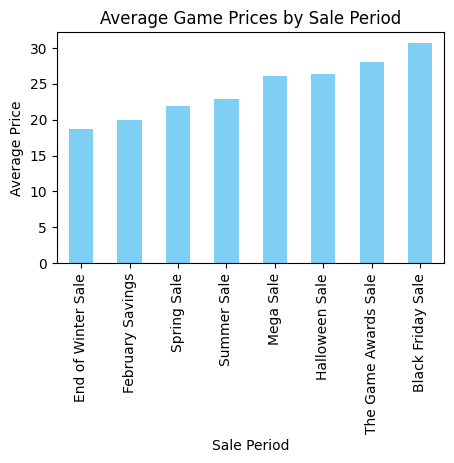

In [24]:
#filter out the 'Other' sale period
avg_price_by_sale_period = games[games['sale_period'] != 'Other'].groupby('sale_period')['price'].mean().sort_values()

print("Average game prices by sale period:")
print(avg_price_by_sale_period)

# visulization
plt.figure(figsize=(5, 3))
avg_price_by_sale_period.plot(kind='bar', color='#7fcef3')
plt.title('Average Game Prices by Sale Period')
plt.xlabel('Sale Period')
plt.ylabel('Average Price')
plt.xticks()
plt.show()

> #### **Conclusion**:
> ##### * Games released during Black Friday and The Game Awards sales tend to have the highest average prices. This may reflect the fact that premium games or highly anticipated titles are often launched or promoted during these key holiday sales events.
> ##### * The End of Winter Sale has the lowest average price, followed by the Spring Sale, suggesting these periods may target more budget-conscious buyers.

#### Analyze platform availability based on sale periods

In [25]:
games['platform'][:10]

0        Windows
1        Windows
2    Windows,Mac
3    Mac,Windows
4            NaN
5        Windows
6        Windows
7        Windows
8        Windows
9        Windows
Name: platform, dtype: object

In [26]:
games['platform'] = games['platform'].fillna('')
games['platform_count'] = games['platform'].str.split(',').apply(len)

In [27]:
avg_platform_sales = games.groupby('sale_period')['platform_count'].mean().sort_values()
print(avg_platform_sales)

sale_period
End of Winter Sale      1.000000
Summer Sale             1.102564
Spring Sale             1.121951
Mega Sale               1.158730
February Savings        1.178571
Other                   1.199695
Halloween Sale          1.300000
Black Friday Sale       1.400000
The Game Awards Sale    1.400000
Name: platform_count, dtype: float64


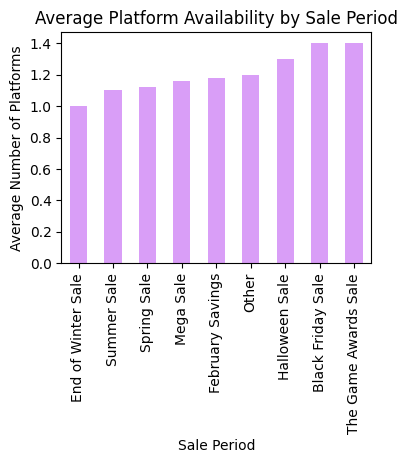

In [28]:
plt.figure(figsize=(4, 3))
avg_platform_sales.plot(kind='bar', color='#d99ef7')
plt.title('Average Platform Availability by Sale Period')
plt.xlabel('Sale Period')
plt.ylabel('Average Number of Platforms')
plt.xticks()
plt.show()

> #### **Conclusion**:
> ##### * Games released during The Game Awards and Black Friday sales are more likely to be available on multiple platforms. This indicates that developers and publishers aim to maximize their audience reach during these key sales events by making games available across various platforms (e.g., Windows, Mac).
> ##### * End of Winter Sale has the lowest platform availability, with an average of just 1.0, indicating fewer games released during this period are cross-platform.

### 5) Does the length or sentiment of a game’s description correlate with its price, genre, or developer reputation?
- explore whether longer or more positive/negative descriptions play a role in the game’s perceived value and pricing strategy

In [29]:
games_desc = games.copy()

In [30]:
games_desc['description_length'] = games_desc['description'].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)
print(games_desc[['description', 'description_length']].head())

                                         description  description_length
0  You are an Assassin, a warrior shrouded in sec...                  35
1  When all the villains in Arkham Asylum team up...                  53
2                            You Can't Stop Progress                   4
3    SHADOW COMPLEX IS BACK....AND BETTER THAN EVER!                   7
4  In 2013, the world was devastated by an apocal...                  45


#### Sentiment Analysis
- will use this basic 'textblob' package for kaggle environment

In [31]:
from textblob import TextBlob
games_desc['desc_sentiment'] = games_desc['description'].apply(lambda x: TextBlob(x).sentiment.polarity if pd.notna(x) else 0)

# sentiment scores
print(games_desc[['description', 'desc_sentiment']].head())

                                         description  desc_sentiment
0  You are an Assassin, a warrior shrouded in sec...        0.500000
1  When all the villains in Arkham Asylum team up...        0.169551
2                            You Can't Stop Progress        0.000000
3    SHADOW COMPLEX IS BACK....AND BETTER THAN EVER!        0.162500
4  In 2013, the world was devastated by an apocal...       -0.004545


* #### sentiment and price

In [32]:
sentiment_price_corr = games_desc[['desc_sentiment', 'price']].corr()
print("Correlation between sentiment and price:\n", sentiment_price_corr)

Correlation between sentiment and price:
                 desc_sentiment     price
desc_sentiment        1.000000  0.031717
price                 0.031717  1.000000


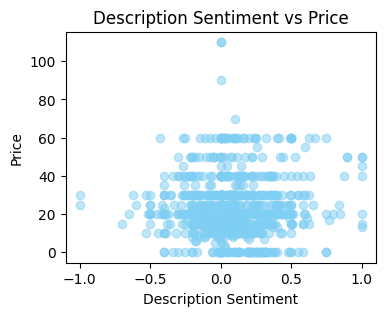

In [33]:
plt.figure(figsize=(4, 3))
plt.scatter(games_desc['desc_sentiment'], games_desc['price'], alpha=0.5, color='#7fcef3')
plt.title('Description Sentiment vs Price')
plt.xlabel('Description Sentiment')
plt.ylabel('Price')
plt.show()

* #### Description length and price

In [34]:
length_price_corr = games_desc[['description_length', 'price']].corr()
print("Correlation between description length and price:\n", length_price_corr)

Correlation between description length and price:
                     description_length     price
description_length            1.000000 -0.056555
price                        -0.056555  1.000000


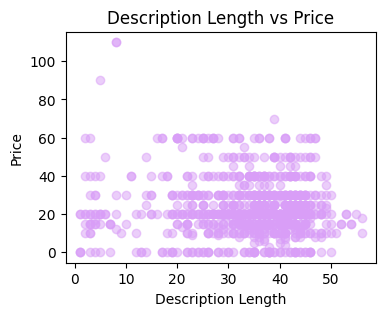

In [35]:
plt.figure(figsize=(4, 3))
plt.scatter(games_desc['description_length'], games_desc['price'], alpha=0.5, color='#d99ef7')
plt.title('Description Length vs Price')
plt.xlabel('Description Length')
plt.ylabel('Price')
plt.show()

In [36]:
import seaborn as sns

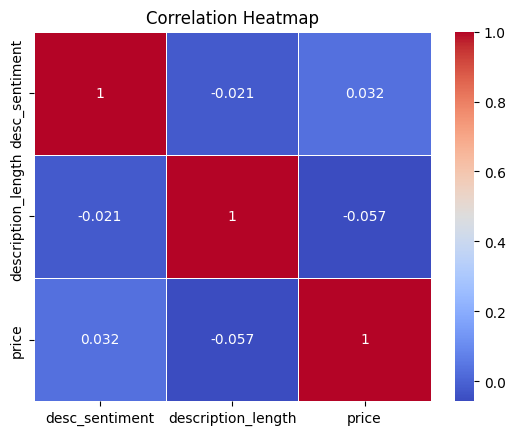

In [37]:
corr_matrix = games_desc[['desc_sentiment', 'description_length', 'price']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [38]:
sentiment_by_genre = games_desc.groupby('genres')[['desc_sentiment', 'description_length', 'price']].mean()
print("Average sentiment and description length by genre:\n", sentiment_by_genre)

Average sentiment and description length by genre:
                                            desc_sentiment  description_length  \
genres                                                                          
ACTION                                           0.277350           26.666667   
ACTION,ADVENTURE                                -0.043810           34.666667   
ACTION,ADVENTURE,CASUAL                         -0.160000           33.000000   
ACTION,ADVENTURE,CITY_BUILDER                    0.029545           29.000000   
ACTION,ADVENTURE,CO_OP                           0.079167           43.000000   
...                                                   ...                 ...   
TURN_BASED,SINGLE_PLAYER,STEALTH                -0.090909           29.000000   
TURN_BASED,STRATEGY                              0.041667           34.000000   
TURN_BASED,STRATEGY,4X                           0.412121           36.000000   
TURN_BASED,STRATEGY,FANTASY,SINGLE_PLAYER        0.125000

In [39]:
sentiment_by_developer = games_desc.groupby('developer')[['desc_sentiment', 'description_length', 'price']].mean()
print("Average sentiment and description length by developer:\n", sentiment_by_developer)

Average sentiment and description length by developer:
                                             desc_sentiment  \
developer                                                    
 Black Forest Games,Pandemic Studios             -0.092593   
 Casey Donnellan Games LLC                       -0.204167   
 Croteam                                         -0.200000   
 DESTINYbit                                      -0.183333   
 Dark Crystal Games                              -0.233333   
...                                                    ...   
id Software,Nightdive Studios,MachineGames        0.200000   
itch.io                                           0.032468   
noio                                             -0.025000   
thatgamecompany                                   0.184167   
tinyBuild Games                                  -0.527778   

                                            description_length  price  
developer                                                        

> #### **Conclusion**:
> ##### * Sentiment and Price: the correlation between sentiment and price is very low (0.032), indicating that the sentiment of a game's description (whether positive or negative) has minimal impact on its pricing.
> ##### * Description Length and Price: the correlation between description length and price is slightly negative (-0.057), suggesting that longer descriptions do not necessarily correlate with higher or lower prices.
> ##### * The sentiment and length of a game’s description do not have a significant impact on its price. These elements are likely not primary factors in the perceived value and pricing strategies for games in this dataset. Other factors, such as the genre, developer reputation, and external market forces, might play a more substantial role in determining game prices.

## Summary:
* ### Pricing influences: 
Factors such as genre and developer play a role in game pricing, with some developers and genres consistently pricing games higher. However, specific features like release year or game descriptions have a limited impact on pricing.

* ### Genre-platform dynamics:
Certain genres, such as RPGs and 4X strategy games, tend to have higher price points. These price differences also vary across platforms, suggesting platform availability might influence pricing strategies.

* ### Seasonality in releases: 
Game releases tend to peak towards the end of the year, particularly during major sale periods like Black Friday and the Holiday season. This indicates that developers strategically time releases to align with periods of high user engagement and sales.

* ### Sale periods and pricing: 
Games released during key sales events such as the Game Awards Sale and Black Friday tend to have higher prices, while smaller sales like the End of Winter Sale period are associated with lower-priced releases. Additionally, platform availability tends to increase during more significant sale periods.

* ### Sentiment and description Length:
Surprisingly, neither the sentiment nor the length of game descriptions show a strong correlation with pricing. This could be due to the basic package I used in this notebook. While certain genres and developers have more positive or longer descriptions, these do not appear to be major factors in determining a game's price.